# NLP for Movie Plots
*Hongyuan Jin, Eunseo Kang, Paige Harris, and Viki Papadakis*

## Purpose
We use natural language processing tools to find similar movies based on their summary plots.

## Methodology
- TF-IDF
- LDA

## WIP - improvements
Todos:
- replace character names with 'character'
- verify the clustering efficiency
-

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import for Python
We import all the required Python libraries

In [2]:
import os
# print("Current Working Directory " , os.getcwd())
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

import matplotlib as plt
# import matplotlib.pyplot as pplt

import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eunseo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eunseo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Library import for R
We enable R in the notebook and import all the required libraries.

In [4]:
pip install rpy2 --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext rpy2.ipython

D:\anaconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning:

The symbol 'quartz' is not in this R namespace/package.



In [4]:
%%R
# install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
library(fixest)
library(dplyr)
library(tidyr)
library(tidyverse)
# install.packages("lmtest")
library(lmtest)
library(sandwich)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


R[write to console]: -- Attaching packages --------------------------------------- tidyverse 1.3.1 --

R[write to console]: v tibble  3.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

R[write to console]: -- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: 'zoo'


R[write to console]: The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




## Local library import
We import all the required local libraries

In [7]:
# Include local library paths
import sys
sys.path.append('C:/Users/Eunseo/Documents/R/win-library/4.1') # uncomment and fill to import local libraries

# Import local libraries

# Data import
- Movie plots (*movies_df*)
    - source:

- Other movie attributes (*movie_other*)
    - source:

- Top star list data (*topstar*)
    - source:

## We first retrieve the data for movie summary plots.

In [8]:
movies_df = pd.read_csv('C:/Users/Eunseo/Documents/pstat234-final-project-main/pstat234-final-project-main/wiki_movie_plots_deduped.csv')
movies_df.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Data for Movie Plots
We subset the data for movies:
- Produced in the US
- Released between 1990 and 2010

In [9]:
# movies_df_sub = movies_df[(movies_df['Origin/Ethnicity']=="American")].reset_index(drop=True)
movies_df_sub = movies_df[(movies_df['Release Year']>=1990) &
                          (movies_df['Release Year']<=2010) &
                          (movies_df['Origin/Ethnicity']=="American")].\
    reset_index(drop=True)
movies_df_sub.head(5)
# 4631 movies to analyze

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1990,The Adventures of Ford Fairlane,American,Renny Harlin,"Andrew Dice Clay, Wayne Newton, Priscilla Pres...",comedy,https://en.wikipedia.org/wiki/The_Adventures_o...,Ford Fairlane (Andrew Dice Clay) is seen sitti...
1,1990,"After Dark, My Sweet",American,James Foley,"Jason Patric, Rachel Ward, Bruce Dern",mystery,"https://en.wikipedia.org/wiki/After_Dark,_My_S...","Ex-boxer Kevin ""Kid"" Collins is a drifter and ..."
2,1990,Air America,American,Roger Spottiswoode,"Mel Gibson, Robert Downey, Jr., Nancy Travis",comedy,https://en.wikipedia.org/wiki/Air_America_(film),"In late 1969, Billy Covington (Robert Downey J..."
3,1990,Alice,American,Woody Allen,"Mia Farrow, Joe Mantegna, William Hurt, Alec B...",comedy,https://en.wikipedia.org/wiki/Alice_(1990_film),Alice Tate is an upper-class New York housewif...
4,1990,Almost an Angel,American,John Cornell,"Paul Hogan, Elias Koteas, Charlton Heston",comedy,https://en.wikipedia.org/wiki/Almost_an_Angel,"Terry Dean (Paul Hogan), a professional burgla..."


In [10]:
movies_df_sub['Plot'].apply(len).describe()

count     4631.000000
mean      3194.705031
std       1759.174164
min         35.000000
25%       1916.500000
50%       3430.000000
75%       4205.000000
max      25123.000000
Name: Plot, dtype: float64

The above says that each plot has on average 3195 tokens (min: 35 and max: 25123).

# Data processing for movie plots

# NLP
We use TF-IDF and LDA to analyze the plot summaries.

## TF-IDF

In [11]:
stemmer = SnowballStemmer("english", ignore_stopwords=False)

normalized = []
totalvocab_tokenized = []
def normalize(X):
    normalized = []
    # totalvocab_tokenized = []
    for x in X:
        words = nltk.word_tokenize(x)
        normalized.append(' '.join([stemmer.stem(word) for word in words if re.match('[a-zA-Z]+', word)]))
        totalvocab_tokenized.extend(words)
    return normalized

pipe = Pipeline([
    ('normalize', FunctionTransformer(normalize, validate=False)),
    ('counter_vectorizer', CountVectorizer(
        max_df=0.8, max_features=200000,
        min_df=0.2, stop_words='english',
        ngram_range=(1, 3)
    )),
    ('tfidf_transform', TfidfTransformer())
])

tfidf_matrix = pipe.fit_transform([x for x in movies_df_sub['Plot']])
print(tfidf_matrix.shape)

(4631, 118)


In [14]:
similarity_distance = 1 - cosine_similarity(tfidf_matrix)
# similarity_distance

We test for finding similar movies for a given title

In [15]:
def find_similar(title):
    index = movies_df_sub[movies_df_sub['Title'] == title].index[0]
    vector = similarity_distance[index, :]
    most_similar = movies_df_sub.iloc[np.argsort(vector)[0:10], 0:2]
    return most_similar

### Example
The movies similar to *Madagascar (2005)* according to TF-IDF.

In [16]:
print(find_similar('Madagascar'))


      Release Year                           Title
3374          2005                      Madagascar
1194          1995      The Pebble and the Penguin
3607          2006                      Happy Feet
1775          1997                 Robinson Crusoe
2602          2001                Saving Silverman
3094          2004     Clifford's Really Big Movie
4497          2010                          Frozen
1269          1996  Alien Nation: The Enemy Within
1955          1998                      The Mighty
1306          1996           Cannibal! The Musical


### Cluster the movies based on the similarity metric from TF-IDF

In [17]:
from sklearn.cluster import KMeans

num_clusters = 23
# print(num_clusters)
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters_tfidf = km.labels_.tolist()

import joblib

joblib.dump(km, 'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters_tfidf_first = km.labels_.tolist()

films = {'title': movies_df_sub["Title"], 'Release_year':  movies_df_sub["Release Year"],
         'Plot':  movies_df_sub['Plot'], 'cluster_tfidf_first': clusters_tfidf_first,
         'Director':  movies_df_sub['Director'], 'Genre':  movies_df_sub['Genre']}
# print(films)
frame = pd.DataFrame(data=films, columns=['title', 'cluster_tfidf_first', 'Genre', 'Release_year', 'Director'])
# print(frame)
print(frame['cluster_tfidf_first'].value_counts())
# # frame.to_csv(r'~/Dropbox/ImmInnHollywood/data/wiki_film_plot/plot_cluster.csv', index=False)

0     425
3     419
11    334
15    298
1     255
19    238
22    207
12    193
13    190
9     184
7     175
18    172
4     169
8     166
20    163
16    158
6     155
21    141
5     129
2     125
14    123
10    113
17     99
Name: cluster_tfidf_first, dtype: int64


#### Visualize the movies within a certain similarity range

In [18]:
frame_select = frame[['title', 'cluster_tfidf_first', 'Genre', 'Release_year']]
frame_select.sort_values(['cluster_tfidf_first']).groupby('cluster_tfidf_first').head(4)[:28]

,title,cluster_tfidf_first,Genre,Release_year
3110,DodgeBall: A True Underdog Story,0,comedy,2004
1185,Operation Dumbo Drop,0,family,1995
3645,Letters from Iwo Jima,0,war,2006
3644,Let's Go to Prison,0,comedy,2006
4624,Winter's Bone,1,"drama, suspense thriller",2010
1267,Alaska,1,adventure,1996
2260,All the Pretty Horses,1,western,2000
1673,Hitler,1,unknown,1997
4593,She's Out of My League,2,romantic comedy,2010
4585,The Romantics,2,romantic comedy,2010


top words in each cluster by TF-IDF

## LDA

TBU-Text explanation

In [19]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = movies_df_sub['Plot'].map(preprocess)
processed_docs[:10]

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    # print(k, v)
    count += 1
    if count > 15:
        break

dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# from pprint import pprint
# for doc in corpus_tfidf:
#     pprint(doc)
#     break

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=23, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=23, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

mdiff, annotation = lda_model_tfidf.diff(lda_model_tfidf)
for index, score in sorted(lda_model_tfidf[bow_corpus[4]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

Topic: 0 
Words: 0.007*"anna" + 0.007*"charli" + 0.006*"jess" + 0.006*"billi" + 0.004*"scott" + 0.004*"brian" + 0.004*"georg" + 0.004*"justin" + 0.004*"paul" + 0.003*"marin"
Topic: 1 
Words: 0.013*"kevin" + 0.009*"marcus" + 0.009*"charli" + 0.006*"presid" + 0.004*"harold" + 0.004*"anim" + 0.004*"jane" + 0.003*"eddi" + 0.003*"jack" + 0.003*"book"
Topic: 2 
Words: 0.007*"carter" + 0.007*"paul" + 0.005*"conni" + 0.004*"terri" + 0.004*"lisa" + 0.004*"mike" + 0.004*"ronni" + 0.004*"franki" + 0.003*"danc" + 0.003*"store"
Topic: 3 
Words: 0.009*"kate" + 0.007*"matt" + 0.005*"band" + 0.004*"mark" + 0.004*"anni" + 0.003*"scott" + 0.003*"jack" + 0.003*"wed" + 0.003*"georg" + 0.003*"record"
Topic: 4 
Words: 0.012*"michael" + 0.008*"danni" + 0.008*"alic" + 0.007*"johnni" + 0.006*"steve" + 0.006*"henri" + 0.005*"mark" + 0.004*"andrew" + 0.004*"joseph" + 0.003*"jam"
Topic: 5 
Words: 0.027*"jack" + 0.004*"eddi" + 0.004*"willi" + 0.004*"traci" + 0.004*"chris" + 0.004*"ship" + 0.004*"danni" + 0.004*"ja

## Import data for names and replace the character names with string 'character'

We find that the topic modeling is affected by the character names.
Below we will replace the names with the string 'Character'

*Data source: Social Security https://www.ssa.gov/oact/babynames/limits.html*

In [25]:
filename = 'C:/Users/Eunseo/Documents/pstat234-final-project-main/pstat234-final-project-main/yob1980.txt'
names = pd.read_csv(filename, delimiter = ",", header=None)
names.columns = ["name", 'gender', 'count']
names.head(5)
names = names.sort_values('count')
# # keep the names with more than 1000 counts
# # names = names[names['count']>=100]
print(names)

              name gender  count
19456          Zoe      M      5
11575      Natacia      F      5
11574      Nasreen      F      5
11573     Nashanda      F      5
11572       Narine      F      5
...            ...    ...    ...
12165        David      M  41920
12164        Jason      M  48170
12163  Christopher      M  49096
0         Jennifer      F  58379
12162      Michael      M  68704

[19457 rows x 3 columns]


In [200]:
# name = names.name.tolist()
# # print(name)
# 'Alice' in name

NameError: name 'names' is not defined

In [20]:
# load names.zip which has more names data txt files
import zipfile
with zipfile.ZipFile('C:/Users/Eunseo/Documents/pstat234-final-project-main/pstat234-final-project-main/names.zip', 'r') as zip_ref:
    zip_ref.extractall('names/')

In [21]:
from pathlib import Path

allnames_files = Path('names').glob('yob*')
# print(allnames_files)
# allnames_files.sort()
allnames_list = list()

for f in allnames_files:
    step_1 = pd.read_csv(f, delimiter = ',', header=None)
    allnames_list.append(step_1)
allnames = pd.concat(allnames_list)
allnames.columns = ["name", 'gender', 'count']
allnames.shape
# drop gender and aggregate the counts groupby names
allnames.drop(['gender'], axis = 1, inplace = True)

In [22]:
# allnames.dtypes
allnames['totalcount'] = allnames['count'].\
    groupby(allnames['name']).transform('sum')
allnames.drop('count', axis = 1, inplace=True)
allnames.head
allnames.describe()

,totalcount
count,2.020863e+06
mean,3.401396e+04
std,1.910011e+05
min,5.000000e+00
25%,2.540000e+02
50%,9.560000e+02
75%,5.048000e+03
max,5.213689e+06


In [23]:
# drop duplicates and keep only the names with count larger than 100
allnames.drop_duplicates(subset='name', inplace= True)
allnames = allnames.sort_values(by = ['totalcount'], ascending=False)
# allnames = allnames[allnames['totalcount']>=5000]
allnames.head()
# there are in total 100364 unique names in the dataset, we will use \
# top 2000 names by the totalcount

,name,totalcount
343,James,5213689
228,John,5163958
514,Robert,4849738
987,Michael,4405274
286,William,4159868


replace every name in the plot with character

In [233]:
# # DO NOT NEED TO RUN
# # ALERT: THIS CELL TAKES VERY LONG TO RUN
# # The name is a list from the names data of yob1980.txt
# for i in movies_df_sub.index:
#     for tag in name:
#         movies_df_sub.Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', movies_df_sub.Plot[i])
#
# # Plot.to_csv('test.csv', index=False)

TypeError: 'Series' object is not callable

In [36]:
%%time
# # DO NOT NEED TO RUN
# ALERT: THIS CELL TAKES EVEN LONGER TO RUN
# The name is a list from the all names data
# there are in total 100364 unique names in the dataset, we will use \
# top 2000 names by the totalcount
name = allnames.name.to_list()
for i in movies_df_sub.index:
    for tag in name[:2000]:
        movies_df_sub.Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', movies_df_sub.Plot[i])

KeyboardInterrupt: 

In [37]:
# save the new movie plot to data
movies_df_sub.to_csv('replaced_character_movie_plots.csv', index=False)

In [38]:
# replace the plots with the rest of the names
for i in movies_df_sub.index:
    for tag in name[:400]:
        movies_df_sub.Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', movies_df_sub.Plot[i])

KeyboardInterrupt: 

In [106]:
# %%time
# name = allnames.name.to_list()
# for tag in name[:100]:
#     # print(tag)
#     nameexp = re.compile(r'\b'+tag+r'\b')
#     for i in movies_df_sub.index[:100]:
#         movies_df_sub.Plot[i] = nameexp.sub('Character', movies_df_sub.Plot[i])

CPU times: user 4.85 s, sys: 62.3 ms, total: 4.91 s
Wall time: 4.91 s


In [114]:
# %%time
# from multiprocessing import Pool
#
# name = allnames.name.to_list()
#
# def f(x):
#     for tag in name[:5]:
#         re.sub(r'\b' + tag + r'\b', 'Character', x)
#
# if __name__ == '__main__':
#     with Pool(4) as p:
#         p.map(f, movies_df_sub.Plot[:5])


KeyboardInterrupt: 

KeyboardInterrupt: 

TF-IDF with the updated plot summaries

load the data for updated plots

In [28]:
new_movies_df = pd.read_csv("replaced_character_movie_plots.csv")
new_movies_df.Plot[5]

"Aspiring comic book artist Josh Baker (Character Roberts) meets a young woman named Character (Janine Turner) on the streets of New York City, who proceeds to collapse and is rushed to a hospital by an ambulance. When Josh arrives at the hospital, he is shocked to find that there is no record of Character ever being admitted and he soon learns another startling discovery, Character's roommate also vanished after being picked up by the same ambulance.\r\nConvinced that there is some sort of conspiracy going on, Josh proceeds to investigate the disappearances, despite the overt disdain and discouragement from Lt. Character (Character Character Jones).[1]"

In [29]:
tfidf_matrix = pipe.fit_transform([x for x in new_movies_df['Plot']])
print(tfidf_matrix.shape)

from sklearn.cluster import KMeans

num_clusters = 23
# print(num_clusters)
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters_tfidf = km.labels_.tolist()

import joblib

joblib.dump(km, 'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

films = {'title': new_movies_df["Title"], 'Release_year':  new_movies_df["Release Year"],
         'Plot':  new_movies_df['Plot'], 'cluster': clusters_tfidf,
         'Director':  new_movies_df['Director'], 'Genre': new_movies_df['Genre']}
# print(films)
frame = pd.DataFrame(data=films, columns=['title', 'cluster', 'Genre', 'Release_year', 'Director'])
# print(frame)
print(frame['cluster'].value_counts())
# frame.to_csv(r'~/Dropbox/ImmInnHollywood/data/wiki_film_plot/plot_cluster.csv', index=False)

(4631, 120)
11    383
6     381
15    377
19    323
14    261
0     254
5     246
16    223
10    196
4     185
22    174
12    156
2     155
17    152
3     150
9     146
21    145
7     142
13    137
8     130
18    105
20    105
1     105
Name: cluster, dtype: int64


Word Cloud for the TF-IDF

In [30]:
from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in new_movies_df.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

Word Cloud with all movie plots

In [31]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


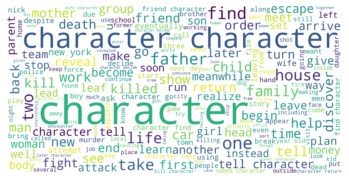

In [32]:
from wordcloud import WordCloud, STOPWORDS
unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

Word cloud with all movie plots for the most important words using countervectorizer

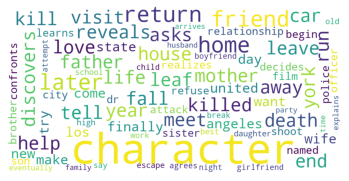

In [33]:
# the most important words in messages using countvectorizer
cv = CountVectorizer(analyzer = "word",stop_words = 'english', max_features = 100, ngram_range=(2,2))
important_words = cv.fit_transform(plots)
fig_words = cv.vocabulary_

#wordcloud for important words
unique_data=(" ").join(fig_words)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(unique_data)
plt.pyplot.imshow(wordcloud)
plt.pyplot.axis("off")
plt.pyplot.show()
plt.pyplot.close()

LDA with the updated plot summaries

In [34]:
from pprint import pprint

In [35]:
processed_docs = new_movies_df['Plot'].map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 15:
        break

dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

# mdiff, annotation = lda_model_tfidf.diff(lda_model_tfidf)
# for index, score in sorted(lda_model_tfidf[bow_corpus[4]], key=lambda tup: -1*tup[1]):
#     print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

0 abet
1 acquir
2 agenc
3 aid
4 amo
5 assist
6 band
7 beach
8 beauti
9 begin
10 belov
11 bidder
12 bit
13 bizarr
14 black
15 blood
[(0, 0.07951296749590873),
 (1, 0.08126917124945505),
 (2, 0.07275509214079737),
 (3, 0.12700575138399228),
 (4, 0.06264939116270807),
 (5, 0.05422567358484346),
 (6, 0.090330200321645),
 (7, 0.09068886906179432),
 (8, 0.05416402052625496),
 (9, 0.05643972108705461),
 (10, 0.057570027661797744),
 (11, 0.04826197598608267),
 (12, 0.10392577858416768),
 (13, 0.06399275461000199),
 (14, 0.07713075299438385),
 (15, 0.05530299948663403),
 (16, 0.05786255643515473),
 (17, 0.06640939636521863),
 (18, 0.05749753924713678),
 (19, 0.09698673428001069),
 (20, 0.06876887334212675),
 (21, 0.1008080306474888),
 (22, 0.20392040631356864),
 (23, 0.05569708025613902),
 (24, 0.07275509214079737),
 (25, 0.07868794017099576),
 (26, 0.08735535034091252),
 (27, 0.08126917124945505),
 (28, 0.05102900050799836),
 (29, 0.05019982620283043),
 (30, 0.07770100866512497),
 (31, 0.07585

### Visualize the plot text (word cloud)

- Overall topic
- US-born director
- Foreign-born director
- Genre

## Import the data with other movie attributes

In [36]:
'Jeffrey' in allnames.name.to_list()

True

In [37]:
movies_other = pd.read_csv('C:/Users/Eunseo/Documents/pstat234-final-project-main/pstat234-final-project-main/df_pstat234.csv')
movies_other.head(5)

,Name,Dirct1,Prodc1,Distributor,Cinematographer1,Actor1,Actor2,Actor3,Actor4,Actor5,Genre,us.year,us.quarter,domestic_bo,budget_nielsen,budget_numbers,director_imm,director_continent,director_country,director_gender,director_race,international_bo
0,Foxy Brown,Jack Hill,Buzz Feitshans,NaN,Brick Marquard,Pam Grier,Antonio Fargas,Peter Brown,Terry Carter,Kathryn Loder,Action,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9 1/2 Ninjas,Aaron Barsky,John Morrissey,Republic Pictures Productions,Fernando Arguelles,Michael Phenicie,Andee Gray,Robert Fieldsteel,Magda Harout,"Tommy ""Tiny"" Lister Jr.",Action,1990,NaN,NaN,1500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alligator II: The Mutation,Jon Hess,Brandon Chase,NaN,Joseph Mangine,Joseph Bologna,Dee Wallace Stone,Woody Brown,Holly Gagnier,Richard Lynch,Horror,1990,NaN,NaN,6000000.0,NaN,Native-born,North America (US),US,NaN,NaN,NaN
3,Back to Back,John Kincade,Brad Krevoy,Concorde Productions,James L Carter,Bill Paxton,Todd Field,Apollonia Kotero,Ben Johnson,Luke Askew,Drama,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Behind the Mask,Warren Chaney,Warren Chaney,NaN,NaN,Deborah Winters,John Swayze,Roy Alan Wilson,Kevin Hickman,Steve Ward,Action,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Import the data with big star names
*Source: https://www.imdb.com/list/ls058011111/?sort=list_order,asc&mode=detail*
*Scraped, code attached separately*

In [38]:
topstar = pd.read_csv('C:/Users/Eunseo/Documents/pstat234-final-project-main/pstat234-final-project-main/topstar.csv')
topstar.head(5)
topstar =topstar.Name.str.lstrip(' ') #I added this line to get rid of the space in front of each name.

## merge the data frames
- other movie attributes (*movies_other*)
- plot clustering with updated plots (*frame*)
- top star indicator (*topstar*)

In [40]:
movies_other['topstar']=0

,Name,Dirct1,Prodc1,Distributor,Cinematographer1,Actor1,Actor2,Actor3,Actor4,Actor5,Genre,us.year,us.quarter,domestic_bo,budget_nielsen,budget_numbers,director_imm,director_continent,director_country,director_gender,director_race,international_bo,topstar
0,Foxy Brown,Jack Hill,Buzz Feitshans,NaN,Brick Marquard,Pam Grier,Antonio Fargas,Peter Brown,Terry Carter,Kathryn Loder,Action,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,9 1/2 Ninjas,Aaron Barsky,John Morrissey,Republic Pictures Productions,Fernando Arguelles,Michael Phenicie,Andee Gray,Robert Fieldsteel,Magda Harout,"Tommy ""Tiny"" Lister Jr.",Action,1990,NaN,NaN,1500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Alligator II: The Mutation,Jon Hess,Brandon Chase,NaN,Joseph Mangine,Joseph Bologna,Dee Wallace Stone,Woody Brown,Holly Gagnier,Richard Lynch,Horror,1990,NaN,NaN,6000000.0,NaN,Native-born,North America (US),US,NaN,NaN,NaN,0
3,Back to Back,John Kincade,Brad Krevoy,Concorde Productions,James L Carter,Bill Paxton,Todd Field,Apollonia Kotero,Ben Johnson,Luke Askew,Drama,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Behind the Mask,Warren Chaney,Warren Chaney,NaN,NaN,Deborah Winters,John Swayze,Roy Alan Wilson,Kevin Hickman,Steve Ward,Action,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13011,You Again,Andy Fickman,Andy Fickman,Walt Disney,David Hennings,Kristen Bell,Jamie Lee Curtis,Sigourney Weaver,Odette Annable,Victor Garber,Comedy,2010,3.0,25677801.0,20000000.0,20000000.0,Native-born,North America (US),US,Male,Caucasian,7136892.0,0
13012,You Will Meet a Tall Dark Stranger,Woody Allen,Letty Aronson,Sony Pictures,Vilmos Zsigmond,Anthony Hopkins,Josh Brolin,Naomi Watts,Freida Pinto,Antonio Banderas,Comedy,2010,3.0,3247816.0,NaN,15000000.0,Native-born,North America (US),US,Male,Caucasian,35287932.0,0
13013,You Won't Miss Me,Ry Russo-Young,Ry Russo-Young,Meese Productions,Kitao Sakurai,Stella Schnabel,Simon O'Connor,Carlen Altman,Rene Ricard,Donald Cumming,Drama,2010,4.0,2240.0,NaN,NaN,Native-born,North America (US),US,Female,Caucasian,NaN,0
13014,Youth in Revolt,Miguel Arteta,David Permut,Weinstein/Dimension,Chuy Chavez,Michael Cera,Portia Doubleday,Jean Smart,Zach Galifianakis,Erik Knudsen,Drama,2010,1.0,15281286.0,18000000.0,18000000.0,Foreign-born,Latin America,Puerto Rico,Male,Latinx/Hispanic,4400000.0,0


We generate top star indicator for each movie if one of the main actors is on the list of top star from the above source.
We run loops to make a binary variable 'topstor' which is 1 is any of Actor1-Actor5 falls into the 1000 topstars, 0 otherwise.

In [53]:
#Do not run this cell! It takes more than two hours! I saved the result file as 'merged with topstar.csv' and we will use that for the following step.
#for j in range(0,1000):
#    for i in range(0,13016):
#        if movies_other.Actor1.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor2.tolist()[i]==topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor3.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor4.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor5.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [55]:
movies_other["topstar"].describe()

count    13016.000000
mean         0.326368
std          0.468902
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: topstar, dtype: float64

In [56]:
# save the merged data with the topstar
movies_other.to_csv('merged with topstar.csv', index=False)

In [54]:
movies_other

,Name,Dirct1,Prodc1,Distributor,Cinematographer1,Actor1,Actor2,Actor3,Actor4,Actor5,Genre,us.year,us.quarter,domestic_bo,budget_nielsen,budget_numbers,director_imm,director_continent,director_country,director_gender,director_race,international_bo,topstar
0,Foxy Brown,Jack Hill,Buzz Feitshans,NaN,Brick Marquard,Pam Grier,Antonio Fargas,Peter Brown,Terry Carter,Kathryn Loder,Action,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,9 1/2 Ninjas,Aaron Barsky,John Morrissey,Republic Pictures Productions,Fernando Arguelles,Michael Phenicie,Andee Gray,Robert Fieldsteel,Magda Harout,"Tommy ""Tiny"" Lister Jr.",Action,1990,NaN,NaN,1500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Alligator II: The Mutation,Jon Hess,Brandon Chase,NaN,Joseph Mangine,Joseph Bologna,Dee Wallace Stone,Woody Brown,Holly Gagnier,Richard Lynch,Horror,1990,NaN,NaN,6000000.0,NaN,Native-born,North America (US),US,NaN,NaN,NaN,0
3,Back to Back,John Kincade,Brad Krevoy,Concorde Productions,James L Carter,Bill Paxton,Todd Field,Apollonia Kotero,Ben Johnson,Luke Askew,Drama,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Behind the Mask,Warren Chaney,Warren Chaney,NaN,NaN,Deborah Winters,John Swayze,Roy Alan Wilson,Kevin Hickman,Steve Ward,Action,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13011,You Again,Andy Fickman,Andy Fickman,Walt Disney,David Hennings,Kristen Bell,Jamie Lee Curtis,Sigourney Weaver,Odette Annable,Victor Garber,Comedy,2010,3.0,25677801.0,20000000.0,20000000.0,Native-born,North America (US),US,Male,Caucasian,7136892.0,1
13012,You Will Meet a Tall Dark Stranger,Woody Allen,Letty Aronson,Sony Pictures,Vilmos Zsigmond,Anthony Hopkins,Josh Brolin,Naomi Watts,Freida Pinto,Antonio Banderas,Comedy,2010,3.0,3247816.0,NaN,15000000.0,Native-born,North America (US),US,Male,Caucasian,35287932.0,1
13013,You Won't Miss Me,Ry Russo-Young,Ry Russo-Young,Meese Productions,Kitao Sakurai,Stella Schnabel,Simon O'Connor,Carlen Altman,Rene Ricard,Donald Cumming,Drama,2010,4.0,2240.0,NaN,NaN,Native-born,North America (US),US,Female,Caucasian,NaN,0
13014,Youth in Revolt,Miguel Arteta,David Permut,Weinstein/Dimension,Chuy Chavez,Michael Cera,Portia Doubleday,Jean Smart,Zach Galifianakis,Erik Knudsen,Drama,2010,1.0,15281286.0,18000000.0,18000000.0,Foreign-born,Latin America,Puerto Rico,Male,Latinx/Hispanic,4400000.0,1


In [57]:
frame

,title,cluster,Genre,Release_year,Director
0,The Adventures of Ford Fairlane,19,comedy,1990,Renny Harlin
1,"After Dark, My Sweet",13,mystery,1990,James Foley
2,Air America,6,comedy,1990,Roger Spottiswoode
3,Alice,2,comedy,1990,Woody Allen
4,Almost an Angel,14,comedy,1990,John Cornell
...,...,...,...,...,...
4626,Wonderful World,12,"comedy-drama, romance",2010,Joshua Goldin
4627,Yogi Bear,15,"family, live-action",2010,Eric Brevig
4628,You Again,10,comedy,2010,Andy Fickman
4629,You Will Meet a Tall Dark Stranger,5,dramedy,2010,Woody Allen


In [58]:
#rename the 'title' column of frame before merging with 'movies_other'
frame = frame.rename(columns = {'title': 'Name'}, inplace = False)

In [116]:
#merge 'frame' to 'movies_other' to make the final data
#First, since you didn't runt the cell to make merged file with topstar, bring it from cvs file
#Uncomment following:
#movies_other=pd.read_csv('C:/Users/Eunseo/Documents/pstat234-final-project-main/pstat234-final-project-main/merged with topstar.csv')
movies_other = pd.merge(movies_other, frame, on='Name')

In [117]:
#Set the Genre variable from the 'movies_other' data as the main variable for Genre of the movie
movies_other = movies_other.rename(columns = {'Genre_x': 'Genre'}, inplace = False)

In [121]:
movies_other

,Name,Dirct1,Prodc1,Distributor,Cinematographer1,Actor1,Actor2,Actor3,Actor4,Actor5,Genre,us.year,us.quarter,domestic_bo,budget_nielsen,budget_numbers,director_imm,director_continent,director_country,director_gender,director_race,international_bo,topstar,cluster,Genre_y,Release_year,Director
0,Back to Back,John Kincade,Brad Krevoy,Concorde Productions,James L Carter,Bill Paxton,Todd Field,Apollonia Kotero,Ben Johnson,Luke Askew,Drama,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,8,"action, drama",1996,Roger Nygard
1,Crash and Burn,Charles Band,David DeCoteau,NaN,Mac Ahlberg,Ralph Waite,Paul E Ganus,Megan Ward,Bill Moseley,Jack McGee,Sci-Fi,1990,NaN,NaN,2500000.0,NaN,Native-born,North America (US),US,NaN,NaN,NaN,0,13,science fiction,1990,Charles Band
2,Love Hurts,Bud Yorkin,Bud Yorkin,NaN,Adam Greenberg,Jeff Daniels,Cynthia Sykes,Judith Ivey,John Mahoney,Cloris Leachman,Comedy,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,17,drama,1991,Bud Yorkin
3,Love Hurts,Barra Grant,Brian Reilly,Lantern Lane Entertainment,Alan Caso,Richard E. Grant,Carrie-Anne Moss,Johnny Pacar,Jenna Elfman,Janeane Garofalo,Romantic Comedy,2009,4.0,NaN,NaN,NaN,Native-born,North America (US),US,NaN,NaN,NaN,1,17,drama,1991,Bud Yorkin
4,Masters of Menace,Daniel Raskov,Lisa M. Hansen,New Line Cinema,Edward J Pei,David Rasche,Catherine Bach,Lance Kinsey,Teri Copley,Ray Baker,Adventure,1990,NaN,NaN,2000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8,unknown,1990,Daniel Raskov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,Winter's Bone,Debra Granik,Anne Rosellini,Roadside Attractions,NaN,Jennifer Lawrence,John Hawkes,Kevin Breznahan,Dale Dickey,Garret Dillahunt,Drama,2010,2.0,6531491.0,2000000.0,2000000.0,Native-born,North America (US),US,Female,Caucasian,9600048.0,1,16,"drama, suspense thriller",2010,Debra Granik
3627,Wonderful World,Joshua Goldin,Glenn Williamson,Magnolia Pictures,Daniel Shulman,Matthew Broderick,Sanaa Lathan,Michael K. Williams,Philip Baker Hall,Jesse Tyler Ferguson,Drama,2010,1.0,8622.0,3000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,12,"comedy-drama, romance",2010,Joshua Goldin
3628,You Again,Andy Fickman,Andy Fickman,Walt Disney,David Hennings,Kristen Bell,Jamie Lee Curtis,Sigourney Weaver,Odette Annable,Victor Garber,Comedy,2010,3.0,25677801.0,20000000.0,20000000.0,Native-born,North America (US),US,Male,Caucasian,7136892.0,1,10,comedy,2010,Andy Fickman
3629,You Will Meet a Tall Dark Stranger,Woody Allen,Letty Aronson,Sony Pictures,Vilmos Zsigmond,Anthony Hopkins,Josh Brolin,Naomi Watts,Freida Pinto,Antonio Banderas,Comedy,2010,3.0,3247816.0,NaN,15000000.0,Native-born,North America (US),US,Male,Caucasian,35287932.0,1,5,dramedy,2010,Woody Allen


In [70]:
# save the final merged data
movies_other.to_csv('final merged data.csv', index=False)

In [176]:
%%R

movies_other = read.csv('~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/df_pstat234.csv')
movies_other[1, ]

              Name         Dirct1 Prodc1                    Distributor
1 300 Year Weekend Victor Stoloff   <NA> Cinerama Releasing Corporation
  Cinematographer1        Actor1          Actor2     Actor3       Actor4
1      Joseph Brun Michael Tolan Sharon Laughlin Roy Cooper Gabriel Dell
     Actor5 Genre us.year us.quarter domestic_bo internaional_bo budget_nielsen
1 M'el Dowd Drama    1970         NA          NA              NA             NA
  budget_numbers director_imm director_continent director_country
1             NA Foreign-born               <NA>         Russian 
  director_gender director_race international_bo
1            <NA>          <NA>               NA


## Exploratory analysis

Here is the summary statistics and the figures to describe the main variables that we are going to use in the regression analysis using the data 'movies_other'

In [110]:
movies_other[["domestic_bo", "budget_nielsen"]].describe()

,domestic_bo,budget_nielsen
count,3.214000e+03,3.233000e+03
mean,3.773813e+07,3.230837e+07
std,5.348099e+07,3.554964e+07
min,1.273000e+03,7.000000e+03
25%,4.552978e+06,1.000000e+07
50%,1.880720e+07,2.000000e+07
75%,4.760670e+07,4.000000e+07
max,4.364710e+08,3.000000e+08


In [77]:
import matplotlib.pyplot as plt

Domestic Box Office

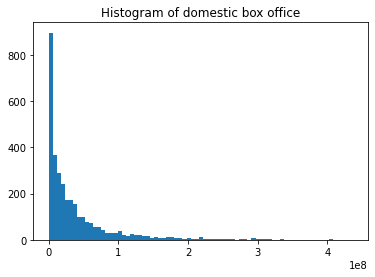

In [82]:
a=plt.hist(movies_other["domestic_bo"],range=(0, movies_other["domestic_bo"].max()),bins='auto')
plt.title("Histogram of domestic box office")
plt.show()

Budget

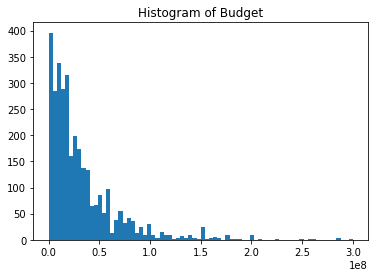

In [83]:
a=plt.hist(movies_other["budget_nielsen"],range=(0, movies_other["budget_nielsen"].max()),bins='auto')
plt.title("Histogram of Budget")
plt.show()

Director's Immigration Status

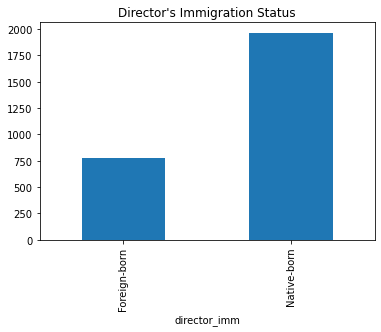

director_imm
Foreign-born     778
Native-born     1967
Name: director_imm, dtype: int64

In [102]:
a= movies_other["director_imm"].groupby(movies_other["director_imm"]).count()
a.plot(kind='bar')
plt.title("Director's Immigration Status")
plt.show()
a

Director's Gender

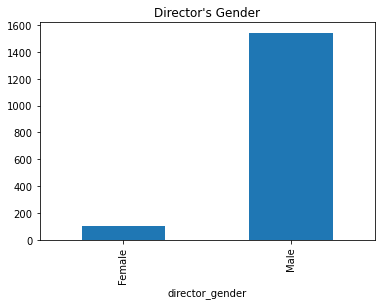

director_gender
Female     101
Male      1543
Name: director_gender, dtype: int64

In [103]:
a= movies_other["director_gender"].groupby(movies_other["director_gender"]).count()
a.plot(kind='bar')
plt.title("Director's Gender")
plt.show()
a

Year

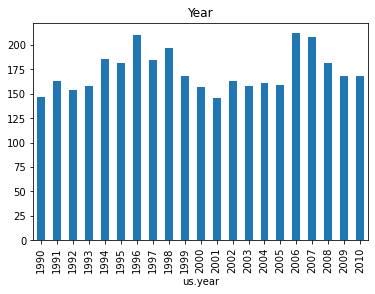

us.year
1990    147
1991    163
1992    154
1993    158
1994    186
1995    182
1996    210
1997    185
1998    197
1999    168
2000    157
2001    146
2002    163
2003    158
2004    161
2005    159
2006    212
2007    208
2008    181
2009    168
2010    168
Name: us.year, dtype: int64

In [122]:
a= movies_other["us.year"].groupby(movies_other["us.year"]).count()
a.plot(kind='bar')
plt.title("Year")
plt.show()
a

Genre

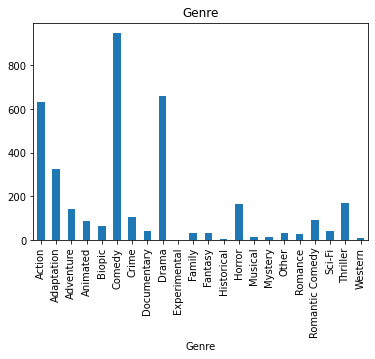

Genre
Action             631
Adaptation         325
Adventure          141
Animated            87
Biopic              66
Comedy             948
Crime              107
Documentary         41
Drama              658
Experimental         1
Family              30
Fantasy             31
Historical           3
Horror             163
Musical             14
Mystery             13
Other               33
Romance             27
Romantic Comedy     92
Sci-Fi              41
Thriller           170
Western              8
Name: Genre, dtype: int64

In [107]:
a= movies_other["Genre"].groupby(movies_other["Genre"]).count()
a.plot(kind='bar')
plt.title("Genre")
plt.show()
a

Distributor

In [109]:
movies_other["Distributor"].groupby(movies_other["Distributor"]).count()

Distributor
20th Century Fox             258
518 Media                      1
ATO Pictures                   1
Academy Pictures               1
After Dark Films               4
                            ... 
World Artists Inc.             1
Yari Film Group                3
Yari Film Group Releasing      4
Zecca Corporation              1
int´l Home Cinema              1
Name: Distributor, Length: 303, dtype: int64

Top Star(Whether the movie is acted by topstars)

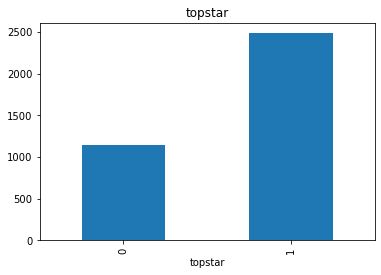

topstar
0    1148
1    2483
Name: topstar, dtype: int64

In [112]:
a= movies_other["topstar"].groupby(movies_other["topstar"]).count()
a.plot(kind='bar')
plt.title("topstar")
plt.show()
a

In [43]:
%%R
# -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

NULL


# Regression analysis


In [16]:
%%R
movies_other=read.csv("C:/Users/Eunseo/Documents/pstat234-final-project-main/pstat234-final-project-main/final merged data.csv",stringsAsFactors=TRUE, header = TRUE)

fit1 = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~ director_imm + director_gender + log(1+budget_nielsen)  | us.year + Genre + Distributor, data =movies_other)
summary(fit1)
# fit2 = feols(log(international_bo + sqrt(1+international_bo^2)) ~ director_imm + log(1+budget_numbers) | us.year + Genre + Distributor, movies_other)
# summary(fit2)

R[write to console]: NOTE: 517 observations removed because of NA values (LHS: 417, RHS: 398).

R[write to console]: Warning:
R[write to console]:  In print.fixest(object, useS4 = FALSE):
 'useS4' is not a valid argument of function print.fixest (fyi, some of
its main arguments are 'n', 'type', 'se' and 'cluster').



OLS estimation, Dep. Var.: log(domestic_bo + sqrt(1 + I(domestic_bo^2)))
Observations: 3,114 
Fixed-effects: us.year: 21,  Genre: 21,  Distributor: 169
Standard-errors: Clustered (us.year) 
                         Estimate Std. Error t value    Pr(>|t|)    
director_immForeign-born 0.126606   0.104115  1.2160 2.38139e-01    
director_immNative-born  0.358214   0.065920  5.4341 2.60000e-05 ***
director_genderFemale    0.406691   0.129283  3.1457 5.08800e-03 ** 
director_genderMale      0.154963   0.055261  2.8042 1.09550e-02 *  
log(1 + budget_nielsen)  0.833373   0.047888 17.4030 1.51000e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.2964     Adj. R2: 0.598739
               Within R2: 0.248073


In [130]:
%%R
fit11st = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~ log(1+budget_nielsen) + director_gender + topstar | us.year + Genre + Distributor, data =movies_other)
summary(fit11st)

R[write to console]: NOTE: 517 observations removed because of NA values (LHS: 417, RHS: 398).

R[write to console]: Warning:
R[write to console]:  In print.fixest(object, useS4 = FALSE):
 'useS4' is not a valid argument of function print.fixest (fyi, some of
its main arguments are 'n', 'type', 'se' and 'cluster').



OLS estimation, Dep. Var.: log(domestic_bo + sqrt(1 + I(domestic_bo^2)))
Observations: 3,114 
Fixed-effects: us.year: 21,  Genre: 21,  Distributor: 169
Standard-errors: Clustered (us.year) 
                        Estimate Std. Error  t value    Pr(>|t|)    
log(1 + budget_nielsen) 0.834081   0.048501 17.19700 1.89000e-13 ***
director_genderFemale   0.477358   0.133614  3.57270 1.90600e-03 ** 
director_genderMale     0.234387   0.046138  5.08010 5.70000e-05 ***
topstar                 0.013445   0.073105  0.18391 8.55936e-01    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.3036     Adj. R2: 0.594419
               Within R2: 0.239715


In [132]:
%%R
fit11 = lm(resid(fit11st) ~ director_imm, movies_other)
summary(fit11)
# fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = ~cluster)
# fit11cl

# fit21st = feols(log(intNationbo_numbers + sqrt(1+intNationbo_numbers^2)) ~ log(1+budget_numbers)| us.year + Genre.Recode + Distributor, df)
# summary(fit21st)
# fit22 = lm(resid(fit21st) ~ dir1.imm, df)
# fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = ~cluster)
# fit22cl


R[write to console]: Error in eval(predvars, data, env) : object 'i.director_imm' not found




Error in eval(predvars, data, env) : object 'i.director_imm' not found


RInterpreterError: Failed to parse and evaluate line 'fit11 = lm(resid(fit11st) ~ i.director_imm, movies_other)\nsummary(fit11)\n# fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = ~cluster)\n# fit11cl\n\n# fit21st = feols(log(intNationbo_numbers + sqrt(1+intNationbo_numbers^2)) ~ log(1+budget_numbers)| us.year + Genre.Recode + Distributor, df)\n# summary(fit21st)\n# fit22 = lm(resid(fit21st) ~ dir1.imm, df)\n# fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = ~cluster)\n# fit22cl\n'.
R error message: "Error in eval(predvars, data, env) : object 'i.director_imm' not found"

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2
3. NLTK: @book{bird2009natural,
  title={Natural language processing with Python: analyzing text with the natural language toolkit},
  author={Bird, Steven and Klein, Ewan and Loper, Edward},
  year={2009},
  publisher={" O'Reilly Media, Inc."}
}


# Appendix

example showing how the preprocessing works

In [30]:
doc_sample = movies_df_sub[movies_df_sub['Title'] == 'Madagascar'].values[0][7]
print(doc_sample)
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


At the Central Park Zoo, Marty the zebra is celebrating his tenth birthday, but has grown bored with his daily routine and longs to experience the wild. Marty's best friend is Alex the lion, who enjoys showing off for the public and his celebrity status as "the King of New York City". Alex attempts to cheer Marty up, but Marty, still unsatisfied, gets some tips from the zoo's penguins—Skipper, Kowalski, Rico, and Private—who are trying to escape the zoo, and follows them out. Alex, Melman the giraffe, and Gloria the hippopotamus pursue Marty in an attempt to convince him to return. The four, along with the penguins and two chimpanzees named Mason and Phil, find themselves at Grand Central Station, where they are quickly sedated via tranquillizer gun when Alex's attempt to communicate with humans is mistaken for aggression. The zoo, under pressure from anti-captivity activists, is forced to ship the escaped animals by sea to a Kenyan wildlife preserve. During their travels, the penguins

testing with name replacement

In [ ]:
miniplot = movies_df_sub.Plot[5]
# miniplot.head()

In [ ]:
# print(miniplot)
# tags = ['Alice', 'John']
for tag in names:
    miniplot = miniplot.replace(tag, 'Character')

print(miniplot)

In [ ]:
for tag in name:
    miniplot = re.sub(r'\b' + tag + r'\b', 'Character', miniplot)
print(miniplot)

In [ ]:
Plot = movies_df_sub.Plot.sample(10)
for i in Plot.index:
    for tag in name:
        Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', Plot[i])
print(Plot)
# Plot.to_csv('test.csv', index=False)

In [ ]:
'Grace' in name